In [3]:
import numpy as np
import matplotlib.pyplot as plt

##### in this notebook, we will look at the dataset of the neural activity in mouse V1 with grating stimuli and behavior monitor (running speed and pupil size) including the following practice:
1. data loading, normalizing and synchronization
2. exploring the relation between neural activity and behaviors
3. visualizing event triggered neural activity
4. orientation tuning analysis

# 1. Data loading, normalizing and synchronization

#### Data import
Here we need to download all the 5 files from (https://uni-bonn.sciebo.de/s/K5hfg9hFElpUGzb) and load them in this notebook. Four of them we will need it now: 
* ***activity.npy***, neural activity (fluorescence) for XX cells across 38100 frames 
* ***stimulus_events.npy***, event onset and offset timestamp for each stimulus, 
* ***pupil_size.npy***, pupil size (diameter), one row for pupil size, one row for corresponding time
* ***running_speed.npy***, running speed,one row for running speed, one row for corresponding time

In [4]:
#rootpath = '/Users/tobiasr/Documents/# Analysis/Student Visit/' # point to the folder where the data is stored and extracted
rootpath = '/home/shanm/adamacs/notebooks/shan/master course teaching/gcamp6s/'

In [5]:
### to load neural activity as numpy array

file_path = rootpath + 'activity.npy' # path to the file
neural_data = np.load(file_path,  allow_pickle=True)
np.shape(neural_data)


(604, 38100)

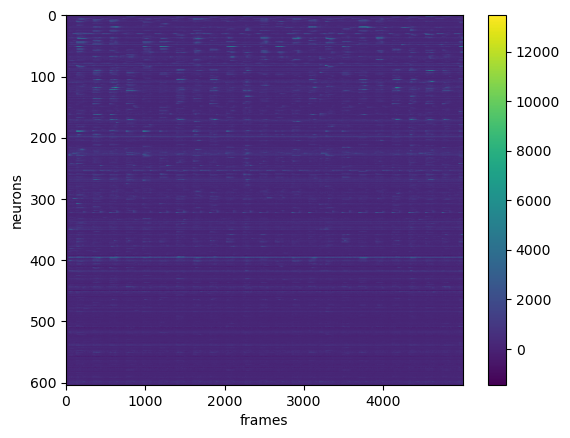

In [6]:
# first some frames of neural activity - play around with start and stop and scale of the colorbar
start = 0
stop = 5000
plt.imshow(neural_data[:,start:stop], aspect='auto')
plt.xlabel('frames')
plt.ylabel('neurons')
plt.colorbar()

#### Calcium signal normalization
Calcium imaging data often contains variability due to experimental conditions, individual neuron activity baselines, and overall fluorescence intensity. Therefore, to standardize the signals, we will use z-score normalization to transforma the calcium signal to have mean of 0 and standard deviation of 1. The normalized signal is calculated as:

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- $\text{x} $ is the original signal value.
- $\mu $ is the mean of the signal.
- $\sigma $ is the standard deviation of the signal.


##### Task: Normalize the neural activity using above formula

In [ ]:
### write you own code
### hint: use np.mean and np.std with axis=1 to normalize each neuron's activity

neural_data_norm = 

#/.../


In [ ]:
start = 0
stop = 5000
plt.imshow(neural_data_norm[:,start:stop], aspect='auto', vmin=-1, vmax=2) # change the range of the colorbar to see the activity better
plt.xlabel('frames')
plt.ylabel('neurons')
plt.colorbar()

##### Task: plot the activity of a single neuron after z-score normalization

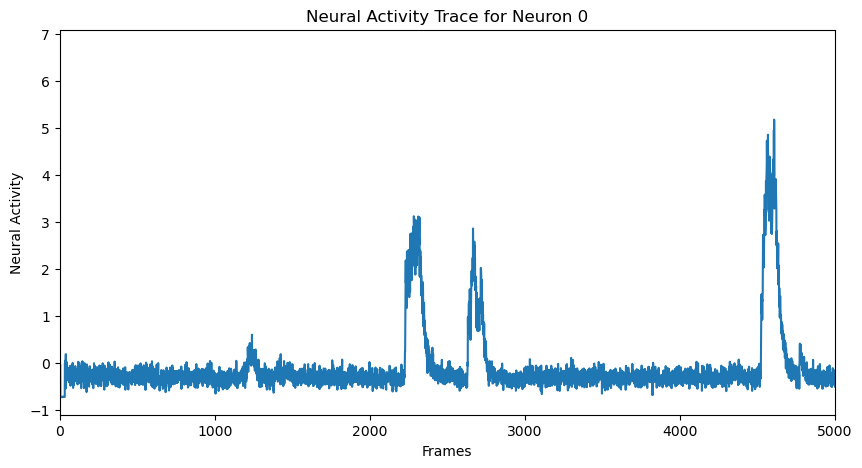

In [ ]:
### write your own code



#/.../



Let's keep loading other files

In [12]:
# to load stimulus_events as numpy array
file_path = rootpath + 'stimulus_events.npy'
stimulus_events_file = np.load(file_path,  allow_pickle=True)
print("To inspect the stimulus_events file, we print one column: ", stimulus_events_file[:,1])
stim = stimulus_events_file[0] # grating direction
stim_on = stimulus_events_file[1] # stimulus onset time
stim_off = stimulus_events_file[2] # stimulus offset time
# convert string into number
stim = np.array([int(item.split(':')[1]) for item in stim], dtype=int)
stim_on = np.array(stim_on, dtype=float)
stim_off = np.array(stim_off, dtype=float)

print("the shape for stimulus_events array is ", np.shape(stim))

To inspect the stimulus_events file, we print one column:  ['Moving_Gratings:120' '13.5389' '16.4875']
the shape for stimulus_events array is  (180,)


##### Task: load file for pupil size and running speed as numpy array

In [ ]:
### write your own code

# to load pupil_size as numpy array
### hint: the pupil size file is consists of data and timestamps, put them into separate arrays: pupil_size and pupil_time


#/.../


print("the shape for pupil_size array is ", np.shape(pupil_size))

# to load running_speed as numpy array
### hint: the running speed file is consists of data and timestamps, put them into separate arrays: running_speed and running_time


#/.../



print("the shape for running_speed array is ", np.shape(running_speed))

the shape for pupil_size array is  (76061,)
the shape for running_speed array is  (2544355,)


#### Data sychronization
These files are all recorded simultaneously for 21min, but you may have already noticed that they are not in the same time length. This is because in different type of recording, we usually have different sampling rate with different devices, e.g. two-photon imaging here is recorded in 30Hz, pupil size is recorded in 60Hz. Therefore, for the convenience of analysis, we will synchronize/align these data into same time unit. There are multiple ways to do data synchronization. Here we would like to focus on neural acitvity related analysis, we will align the timestamps in the other 3 files according to neural activity frames by assigning the closest timestamps. And in the end of the synchronization part, we will get arrays with same length for neural activity, running speed, pupil size; and the event onset & offset will be the corresponding frame number. 

To do this, we will load one more file ***bench2p_frame_times.npy*** to get the corresponding timestamp for each frame of neural activity.

In [14]:
file_path = rootpath + 'bench2p_frame_times.npy'
neural_frame_time = np.load(file_path,  allow_pickle=True)


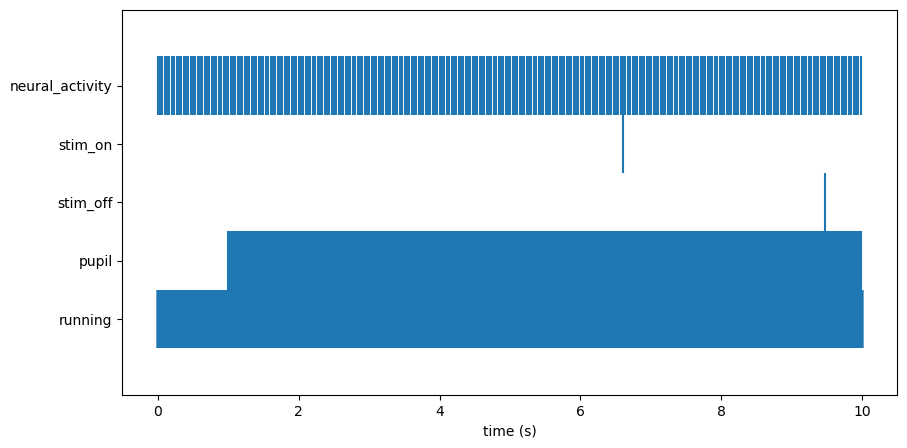

In [15]:
# visualize the timestamps for different types of data
time = 10 # to show 10 sec time window
plt.figure(figsize=(10,5))
plt.eventplot(neural_frame_time[neural_frame_time < time], lineoffsets=4)
plt.eventplot(stim_on[stim_on < time], lineoffsets=3)
plt.eventplot(stim_off[stim_off < time], lineoffsets=2)
plt.eventplot(pupil_time[pupil_time < time], lineoffsets=1)
plt.eventplot(running_time[running_time < time], lineoffsets=0)

plt.yticks([0,1,2,3,4],["running","pupil","stim_off","stim_on","neural_activity"])
plt.xlabel("time (s)")
# plt.xlim(4, 4.5) # to zoom in
plt.show()



In [16]:
# to align stimulus timestamp with the neural activity timestamp
def get_closest_timestamps_stim(stim_timestamps, target_timestamps):
    # Find the closest index in `stim_timestamps` for each `target_timestamp`
    aligned_indices = np.array([np.abs(target_timestamps - t).argmin() for t in stim_timestamps])

    return aligned_indices


In [17]:
# neural activity-aligned frames for stimulus on and off

stim_durations = 3 # duration of each stimulus trial is 3 sec
neural_fs = 30 # sampling rate for neural activity

stim_on_aligned = get_closest_timestamps_stim(stim_on, neural_frame_time)
stim_off_aligned = stim_on_aligned + stim_durations * neural_fs 

In [18]:
def get_closest_timestamps_behav(behav_timestamps, target_timestamps):
    # similarly, we can align the neural activity timestamp with the other data timestamp
    # aligned_indices = np.array([np.abs(behav_timestamps - t).argmin() for t in target_timestamps])

    # to avoid repeat searching, we can use the following code by tracking the searching pointer
    aligned_indices = []
    j = 0  # Searching pointer
    for t in target_timestamps:
        # Move forward in behav_timestamps to find the closest timestamp
        while j < len(behav_timestamps) - 1 and abs(behav_timestamps[j + 1] - t) < abs(behav_timestamps[j] - t):
            j += 1
        aligned_indices.append(j)

    return np.array(aligned_indices)

##### Task: align pupil_size and running_speed with neural activity respectively

In [ ]:
### write your own code
### hint 1. get the aligned frames using above function: get_closest_timestamps_behav()
### hint 2. use the aligned frames to get corresponding data from original data array


#/.../





In [110]:
np.shape(pupil_size_aligned), np.shape(running_speed_aligned), np.shape(neural_data_norm[0])

((38100,), (38100,), (38100,))

##### Task: Plot the aligned pupil size, running speed and an ROI 

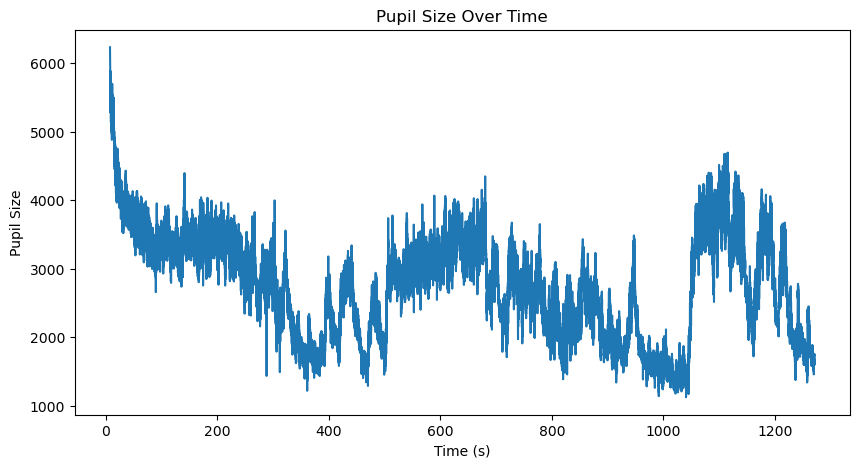

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(pupil_time, pupil_size)
plt.xlabel('Time (s)')
plt.ylabel('Pupil Size')
plt.title('Pupil Size Over Time')
plt.show()

# 2. exploring the relation between neural activity and behaviors
It has been shown that the neural activity can be modulated by behaviors. Here we will explolre how pupil size and running speed is related to neural activity in V1.

In [ ]:
### calculate the correlation between neural activity and pupil size
corr_neural_pupil = np.corrcoef(np.average(neural_data_norm[:,stim_on_aligned[5]:stim_off_aligned[-1]], axis =0), pupil_size_aligned[stim_on_aligned[5]:stim_off_aligned[-1]])


array([[1.        , 0.19913178],
       [0.19913178, 1.        ]])

In [ ]:
corr_neural_pupil

##### Task: calculate the correlation between neural activity and running speed

In [2]:
### write your own code 
### hint: use the same method as above: np.corrcoef()


#/.../




# 3. visualizing event-triggered neural activity
The provided neural activity data is consists of 12 grating directions * 15 repeats of each directions. To analyze the event-triggered neural activity, we need to extract the corresponding neural activity for the same grating directions.

Task: plot two example trials for a neuron with 1s before stim_on and 1s after stim_off

Text(0.5, 1.0, 'neural activity for trial 2, orientation = 300')

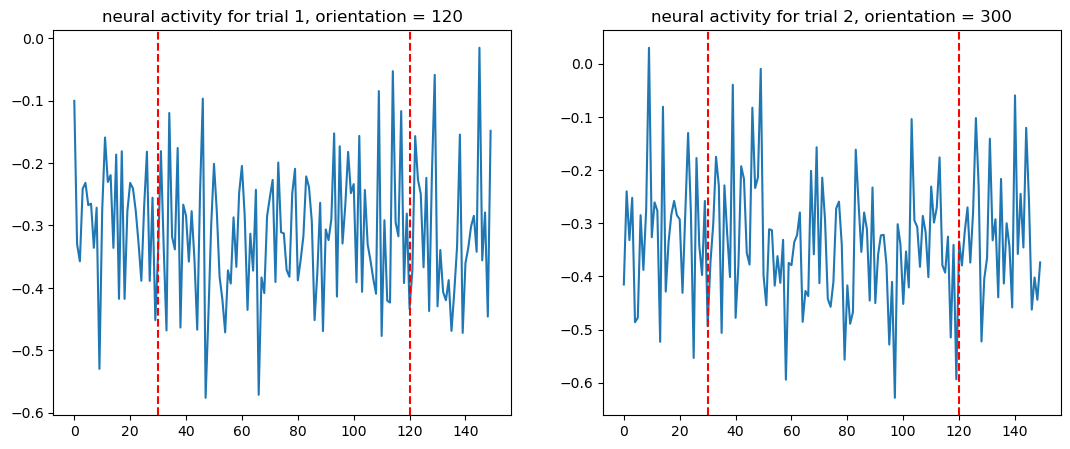

In [ ]:
### write your own code
### hint 1: use stim_on_aligned and stim_off_aligned to get the timepoints for the trial
### hint 2: use plt.axvline() to draw vertical line at stim_on and stim_off timepoints

neuron_id = 0
trial_id_1 = 1
trial_id_2 = 2




#/.../



Since the orientation of stimulus is randomized across time during experiment, we need to extract the neural activity for same direction trials to calculate the tuning curve


In [88]:
stim

array([180, 120, 300,  60,   0, 210, 270, 150,  90,  30, 240, 330, 210,
       150, 120, 180,  30, 300, 330,  90, 270, 240,  60,   0, 330, 270,
       210,  60,  30, 120, 150, 180, 300,   0, 240,  90, 180, 210, 150,
        90,  30, 120, 270, 240,   0, 300,  60, 330,  60, 180, 210, 330,
       270,  90,  30, 120, 240,   0, 300, 150, 120, 180, 240,  30,  90,
       300, 270,  60, 150, 210,   0, 330,  90, 300, 150,  60, 270,   0,
       180,  30, 120, 240, 210, 330, 300, 180, 270,   0, 210,  60, 240,
        30, 120, 150,  90, 330, 270, 210,  60,  30,  90,   0, 120, 330,
       240, 180, 150, 300, 330,   0,  30, 180, 270, 240, 150,  90, 210,
       300,  60, 120, 330,  30, 150, 210, 120, 270,   0, 240,  90,  60,
       180, 300, 270, 300, 330,  60, 210,  90,   0, 240, 120, 180, 150,
        30,  60, 120,  30,  90, 240, 330,   0, 180, 270, 210, 150, 300,
       180, 270, 300, 150,  30,   0, 330, 240,  60, 120, 210,  90,  30,
       180, 300, 240,   0, 150, 330, 120, 210, 270,  60,  90])

In [100]:
# extracting the neural activity for same direction trials
# here is the example how to extract all trials for orientation = 0 
stim_on_aligned_0 =stim_on_aligned[stim==0]
stim_off_aligned_0 =stim_off_aligned[stim==0]

neural_data_0 = [] 
for tr in range(len(stim_on_aligned_0)):
    neural_data_0.append(neural_data_norm[:, stim_on_aligned_0[tr]-30:stim_off_aligned_0[tr]+30])
neural_data_0 = np.array(neural_data_0)

np.shape(neural_data_0)

(15, 604, 150)

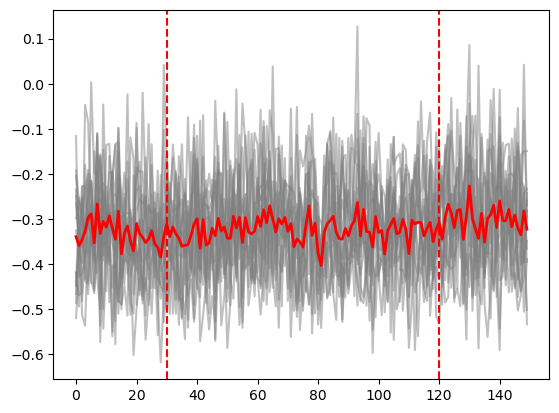

In [101]:
neuron_id = 0
for tr in range(len(neural_data_0)):
    plt.plot(neural_data_0[tr][neuron_id,:], color='gray', alpha=0.5)
plt.plot(np.average(neural_data_0[:,neuron_id,:], axis=0), color='r', linewidth=2)
plt.axvline(30,  color='r', linestyle='--')
plt.axvline(120, color='r', linestyle='--')

Task: extracting the neural activity of same direction trials for all orientations

In [ ]:
### write your own code
### hint: loop above example code for all orientations

orientations = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

#/.../

np.shape(neural_data_all_ori)

(12, 15, 604, 150)

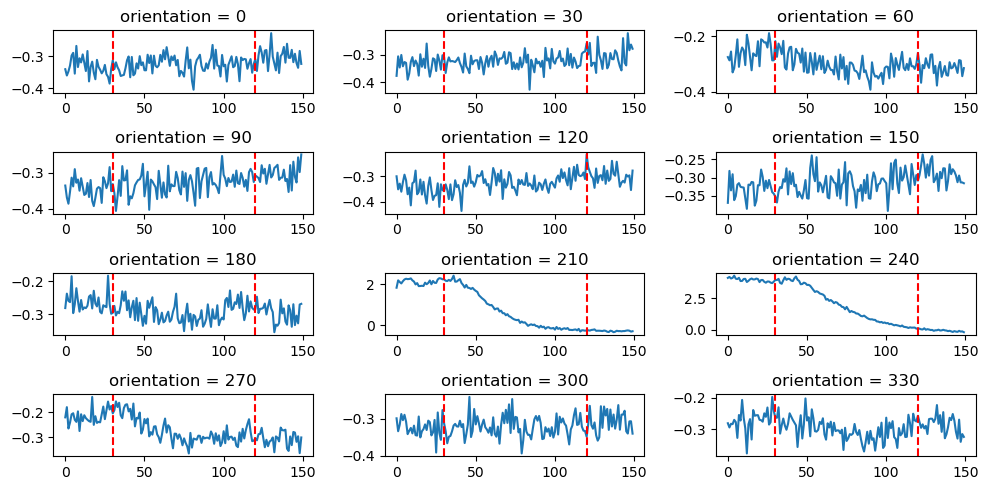

In [103]:
# plot the trial-averaged trace of neuron 0 for all orientations respectively
plt.figure(figsize=(10,5))
for i, ori in enumerate(orientations):
    plt.subplot(4,3,i+1)
    plt.plot(np.average(neural_data_all_ori[i][:,neuron_id,:], axis=0))
    plt.axvline(30,  color='r', linestyle='--')
    plt.axvline(120, color='r', linestyle='--')
    plt.title(f"orientation = {ori}")
plt.tight_layout()

# 4. orientation tuning analysis

to quantify the neural activity induced by grating stimulus, we can subtract the baseline activity from the activity trace. Here we consider the average activity of 1s window before stimulus as baseline. Then the neural activity level during stimulation across different direction is comparable. Therefore, we take the mean value of each averaged neural trace during stimulus (from frame 30 to 120). 


In [104]:
# subtract baseline
neuron_id = 0

avg_activity_n = []
for i in range(len(orientations)):
    # Compute the baseline: average of the first 30 frames
    avg_trace = np.average(neural_data_all_ori[i][:,neuron_id,:], axis=0)
    baseline = np.mean(avg_trace[:30])

    normalized_avg_trace = avg_trace - baseline
    avg_activity_n.append(normalized_avg_trace)
    
avg_activity_n = np.array(avg_activity_n)

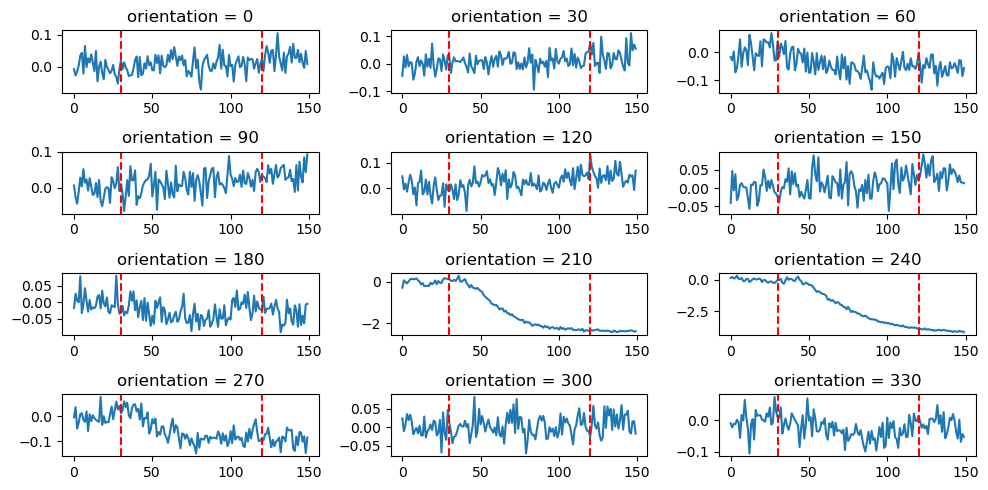

In [105]:
plt.figure(figsize=(10,5))
for i, ori in enumerate(orientations):
    plt.subplot(4,3,i+1)
    plt.plot(avg_activity_n[i])
    plt.axvline(30,  color='r', linestyle='--')
    plt.axvline(120, color='r', linestyle='--')
    plt.title(f"orientation = {ori}")
plt.tight_layout()

Task: calculate the orientation response for all neurons

In [ ]:
### write your own code
### hint1: looping the above code for all neurons: calculate the average activity for each orientation, then subtract the baseline.
### hint2: take the mean value of trial-averaged neural trace during stimulus (i.e. from frame 30 to frame 120), to get one number for each neuron and each orientation.
### hint3: The target array should have shape (620*12)



#/.../



avg_ori_response_all.shape

(604, 12)

#### Visualizing the orientation tuning

In [113]:

def plot_MG_radar(orientations, response, neuron_id):
    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

    # Compute angle of each axis
    orientations_rad = np.deg2rad(orientations)
    orientations_rad = np.concatenate([orientations_rad, orientations_rad[:1]], axis=0)


    response_cir = np.concatenate([response, response[:1]], axis=0)

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi)  # Rotate the chart by 90° counterclockwise
    ax.set_theta_direction(-1)

    # Draw the outline of the radar chart
    ax.plot(orientations_rad, response_cir, linewidth=1, linestyle='solid', color='darkorange')
    ax.fill(orientations_rad, response_cir, alpha=0.2, color='darkorange')

    # Add ticks, labels and limits
    ax.set_xticks(orientations_rad)
    ax.set_title(f"neuron_id = {neuron_id}")
    
    labels = [str(orientation)+"°" for orientation in orientations]
    labels += labels[:1]
    ax.set_xticklabels(labels)
    ax.set_ylim(-1, max(response_cir)+0.5)

    plt.show()

<Figure size 1000x500 with 0 Axes>

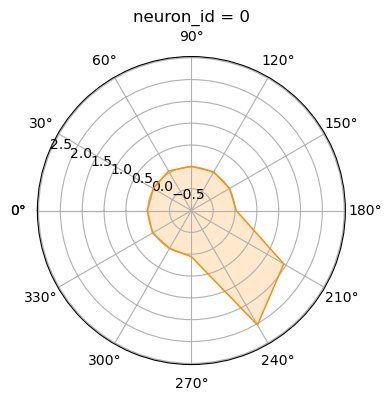

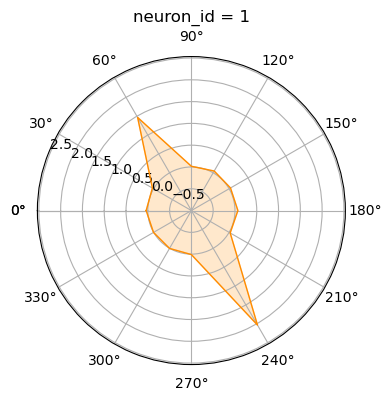

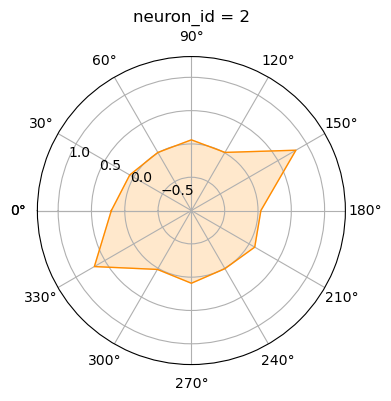

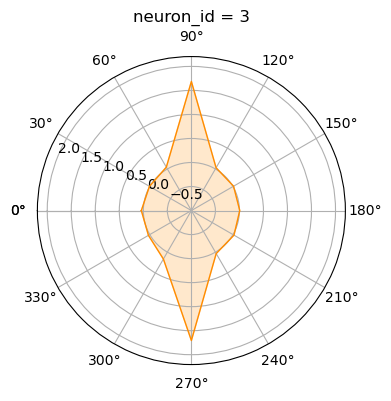

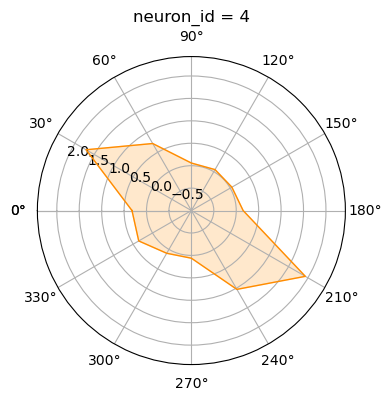

<Figure size 640x480 with 0 Axes>

In [129]:
plt.figure(figsize=(10,5))
for neuron in range(5):
    plot_MG_radar(orientations, np.abs(avg_ori_response_all[neuron]), neuron)
plt.tight_layout()

#### Quantifying orientation selectivity
After visualizing the neural activity corresponding to each orientation, we also want to quantify the orientation selectivity of each neuron by calculating the OSI (orientation selectivity index).

The **Orientation Selectivity Index (OSI)** quantifies how selective a neuron is to specific orientations (Mazurek et al., 2014)

The OSI is calculated as:
$$
\text{OSI} = \frac{\left| \sum R(\theta_i) e^{i \theta_i} \right|}{\sum \left| R(\theta_i) \right|}
$$
where $\theta_i$ is the grating orientations  (e.g., $0^\circ, 30^\circ, \dots, 180^\circ$);  $R(\theta_i)$ is the response for each orientation. $e^{i \theta_i}$ represents the unit vector in the direction $\theta_i$, 


- $\text{OSI} = 0$: Non-selective response.
- $\text{OSI} = 1$: Perfectly selective to one orientation.

The preferred orientation is calculated by:
$$
\theta_{\text{pref}} = \arg(\mathbf{V}_{\text{mean}})
$$
where $\arg$ is the angle of the mean vector.

In [121]:
def compute_osi(orientations, response):

    # Collapse orientations into 0 to 180 degrees
    collapsed_orientations = np.array(orientations) % 180  # Map 180°-apart directions to the same value
    unique_orientations, indices = np.unique(collapsed_orientations, return_inverse=True)

    # Sum responses for equivalent orientations
    collapsed_responses = np.zeros_like(unique_orientations, dtype=float)
    for i in range(len(unique_orientations)):
        collapsed_responses[i] = np.sum(response[indices == i])

    # Convert unique orientations to radians
    unique_orientations_rad = np.deg2rad(unique_orientations)

    # Compute the vector sum
    vector_sum = np.sum(collapsed_responses * np.exp(1j * unique_orientations_rad))

    # Calculate OSI: magnitude of vector sum divided by total response
    osi = np.abs(vector_sum) / np.sum(np.abs(collapsed_responses))

    # Calculate the preferred orientation
    pref_ori_rad = np.angle(vector_sum)  # Angle in radians
    pref_ori_deg = np.rad2deg(pref_ori_rad) % 180  # Normalize to [0, 180)

    return osi, pref_ori_deg


In [ ]:
neuron_id = 0
osi, pref_ori_deg = compute_osi(orientations, avg_ori_response_all[neuron_id])

Task:
Calculate the OSI and preferred orientation angle for other neurons. Try to interprete the calculated results together with radar plots.

In [10]:
### Calculate the OSI and preferred orientation angle for other neurons
### write your own code


#/.../


